In [1]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image, ImageDraw
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.models import resnet50, ResNet50_Weights

from pycocotools.coco import COCO
import requests

In [2]:
# current path
current_path = Path.cwd()

VAL_ANNOTATION_PATH = current_path / "data" / "person_keypoints_val2017.json"
VAL_IMAGE_PATH = current_path / "data" / "val2017"

# Number of keypoints in COCO dataset
NUM_KEYPOINTS = 17

# Input and output image sizes
INPUT_SIZE = (192, 256)   # Width, Height
OUTPUT_SIZE = (64, 48)    # Height, Width (for heatmaps)

# Random seed for reproducibility
SEED = 42

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
class PersonKeypointsDataset(Dataset):
    def __init__(self, annotation_file, image_path, min_keypoints=9, max_samples=None, transform=None, target_transform=None, seed=SEED):
        """
        Custom Dataset for COCO Person Keypoints
        """
        self.coco = COCO(annotation_file)
        self.image_path = str(image_path)
        self.transform = transform
        self.target_transform = target_transform
        self.person_ids = self.coco.getCatIds(catNms=['person'])
        self.img_ids = self.coco.getImgIds(catIds=self.person_ids)

        # Set seeds for reproducibility
        set_seed(seed)
        
        # Build list of (image_id, annotation) tuples
        self.samples = []
        for img_id in self.img_ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.person_ids, iscrowd=False)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                # Include only samples with enough keypoints
                if 'keypoints' in ann and ann['num_keypoints'] >= min_keypoints:
                    self.samples.append((img_id, ann))

        # Randomly sample if we have more samples than max_samples
        if max_samples and max_samples < len(self.samples):
            self.samples = random.sample(self.samples, max_samples)
            print(f"Randomly sampled {len(self.samples)} images from {len(self.samples)} total images")
                        
    def __len__(self):
        """
        Returns the number of samples in the dataset
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Fetches the image and keypoints for the given index.
        """
        img_id, ann = self.samples[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_path, img_info['file_name'])
        if not os.path.exists(img_path):
            raise RuntimeError(f"Image file not found: {img_path}")
        img = Image.open(img_path).convert("RGB")
        
        # Get bounding box
        bbox = ann['bbox']  # [x, y, w, h]
        x, y, w, h = bbox
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
        
        # Crop image to bounding box
        img = img.crop((x1, y1, x2, y2))
        
        orig_w, orig_h = img.size
        
        # Adjust keypoints
        keypoints = np.array(ann['keypoints']).reshape(-1, 3)
        keypoints[:, 0] -= x1
        keypoints[:, 1] -= y1
        
        # Resize image and keypoints
        new_size = INPUT_SIZE  # (width, height)
        img = img.resize(new_size, resample=Image.BILINEAR)
        
        scale_x = new_size[0] / orig_w
        scale_y = new_size[1] / orig_h
        keypoints[:, 0] = (keypoints[:, 0] * scale_x)
        keypoints[:, 1] = (keypoints[:, 1] * scale_y)
        
        # Apply transforms
        if self.transform:
            img = self.transform(img)
        else:
            img = F.to_tensor(img)

        # Convert keypoints to tensor
        keypoints = torch.tensor(keypoints, dtype=torch.float32)
        
        # Generate heatmaps
        if self.target_transform:
            target = self.target_transform(keypoints)
        else:
            target = torch.tensor(keypoints, dtype=torch.float32)
        
        meta = {
            'image_id': img_id,
            'bbox': ann['bbox'],
            'scale': (scale_x, scale_y),
            'crop_coords': (x1, y1, x2, y2),
            'original_image_size': (img_info['width'], img_info['height'])
        }
        
        return img, target, keypoints, meta

In [5]:
class HeatmapGenerator:
    """
    Generates heatmaps for each keypoint.
    Uses Gaussian distributions.
    """
    def __init__(self, output_size, num_keypoints, sigma=2):
        self.output_size = output_size  # (height, width)
        self.num_keypoints = num_keypoints
        self.sigma = sigma
        
    def __call__(self, keypoints):
        heatmaps = np.zeros((self.num_keypoints, self.output_size[0], self.output_size[1]), dtype=np.float32)
        tmp_size = self.sigma * 3
        
        for i in range(self.num_keypoints):
            kp = keypoints[i]
            x, y, v = kp
            if v > 0:
                x = x * self.output_size[1] / INPUT_SIZE[0]
                y = y * self.output_size[0] / INPUT_SIZE[1]
                
                ul = [int(x - tmp_size), int(y - tmp_size)]
                br = [int(x + tmp_size + 1), int(y + tmp_size + 1)]
                
                if ul[0] >= self.output_size[1] or ul[1] >= self.output_size[0] or br[0] < 0 or br[1] < 0:
                    continue
                
                size = 2 * tmp_size + 1
                x_coords = np.arange(0, size, 1, np.float32)
                y_coords = x_coords[:, np.newaxis]
                x0 = y0 = size // 2
                g = np.exp(- ((x_coords - x0) ** 2 + (y_coords - y0) ** 2) / (2 * self.sigma ** 2))
                
                g_x = max(0, -ul[0]), min(br[0], self.output_size[1]) - ul[0]
                g_y = max(0, -ul[1]), min(br[1], self.output_size[0]) - ul[1]
                
                img_x = max(0, ul[0]), min(br[0], self.output_size[1])
                img_y = max(0, ul[1]), min(br[1], self.output_size[0])
                
                heatmaps[i][img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
                
        return torch.tensor(heatmaps, dtype=torch.float32)

In [11]:
import torch.nn.functional as F  # Import neural network functional API
from torchvision.transforms import functional as TF  # Import torchvision's transforms

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)
        

class HighResolutionModule(nn.Module):
    def __init__(self, branches, fusion):
        super(HighResolutionModule, self).__init__()
        self.branches = nn.ModuleList(branches)
        self.fusion = nn.ModuleList(
            [nn.ModuleList([op if op is not None else nn.Identity() for op in sublist])
             for sublist in fusion]
        )

    def forward(self, x):
        # Process each resolution branch
        outputs = [branch(x[i]) for i, branch in enumerate(self.branches)]

        # Ensure matching spatial dimensions before fusion
        max_height = max(output.size(2) for output in outputs)
        max_width = max(output.size(3) for output in outputs)
        
        # Fuse outputs from all branches
        for i in range(len(self.fusion)):
            for j in range(len(outputs)):
                if i == j: continue
                # Apply fusion operation to outputs[j]
                update = self.fusion[i][j](outputs[j])
                
                # Resize update to match the spatial size of outputs[i]
                if update.size(2) != outputs[i].size(2) or update.size(3) != outputs[i].size(3):
                    update = F.interpolate(update, size=(outputs[i].size(2), outputs[i].size(3)), mode='bilinear', align_corners=True)

                # Add the resized update to outputs[i]
                outputs[i] = outputs[i] + update

        return outputs


class HRNet(nn.Module):
    def __init__(self, num_classes):
        super(HRNet, self).__init__()

        # Stem network
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 64, 4)

        # Stage 1: High-resolution branch
        self.stage1 = self._make_layer(BasicBlock, 64, 64, 4)

        # Stage 2: Multi-resolution branches
        self.stage2 = HighResolutionModule(
            branches=[
                self._make_layer(BasicBlock, 64, 64, 4),
                self._make_layer(BasicBlock, 64, 128, 4)
            ],
            fusion=[
                [nn.Identity(), nn.Conv2d(128, 64, kernel_size=1, bias=False)],
                [nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False), nn.Identity()]
            ]
        )

        # Final classifier
        self.fc = nn.Sequential(
            nn.Conv2d(192, 17, kernel_size=1, stride=1),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride=1):
        layers = [block(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Stem
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)

        # Stages
        x = self.stage1(x)
        x = self.stage2([x, F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True)])

        # Classifier
        x = torch.cat([x[0], F.interpolate(x[1], scale_factor=2, mode='bilinear', align_corners=True)], dim=1)
        x = self.fc(x)
        return x

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

target_transform = HeatmapGenerator(output_size=OUTPUT_SIZE, num_keypoints=NUM_KEYPOINTS)

In [13]:
test_dataset = PersonKeypointsDataset(
    annotation_file=VAL_ANNOTATION_PATH,
    image_path=VAL_IMAGE_PATH,
    min_keypoints=9,
    max_samples=None,
    transform=transform,
    target_transform=target_transform
)

# custom collate function to handle meta-information
def collate_fn(batch):
    images, targets, keypoints, metas = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.stack(targets, 0)
    keypoints = torch.stack(keypoints, 0)
    return images, targets, keypoints, metas

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [14]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)

In [15]:
# load the model
model = HRNet(num_classes=NUM_KEYPOINTS).to(device)
model.load_state_dict(torch.load('models/HRNet_model_epoch_1_loss_0.0005904935554594125.pth', map_location=device, weights_only=True))
model.eval()

# Evaluation loop to generate predictions
predictions = []

print("length of test_loader:", len(test_loader))
print()

curr_num_batch = 1
for batch in test_loader:
    print("current batch:", curr_num_batch)
    curr_num_batch += 1
    
    images, _, _, metas = batch
    images = images.to(device)
    batch_size = images.size(0)
    
    with torch.no_grad():
        outputs = model(images)
    
    outputs = outputs.cpu().numpy()
    for i in range(batch_size):
        output_heatmaps = outputs[i]
        meta = metas[i]
        
        # Extract predicted keypoints from heatmaps
        pred_keypoints = []
        for j in range(NUM_KEYPOINTS):
            heatmap = output_heatmaps[j]
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            confidence = float(np.max(heatmap))
            
            # Map x, y back to input image size
            pred_x = (x / OUTPUT_SIZE[1]) * INPUT_SIZE[0]
            pred_y = (y / OUTPUT_SIZE[0]) * INPUT_SIZE[1]
            pred_keypoints.append([pred_x, pred_y, confidence])
        
        pred_keypoints = np.array(pred_keypoints)
        
        # Reverse the resizing
        scale_x, scale_y = meta['scale']
        pred_keypoints[:, 0] /= scale_x
        pred_keypoints[:, 1] /= scale_y
        
        # Reverse the cropping
        x1, y1, _, _ = meta['crop_coords']
        pred_keypoints[:, 0] += x1
        pred_keypoints[:, 1] += y1
        
        # Prepare the prediction dict
        pred_dict = {
            'image_id': int(meta['image_id']),
            'category_id': 1,
            'keypoints': [],
            'score': float(pred_keypoints[:, 2].mean())
        }
        
        keypoints_list = []
        for kp in pred_keypoints:
            keypoints_list.extend([float(kp[0]), float(kp[1]), 1])  # Visibility flag set to 1
        
        pred_dict['keypoints'] = keypoints_list
        
        predictions.append(pred_dict)

length of test_loader: 281

current batch: 1
current batch: 2
current batch: 3
current batch: 4
current batch: 5
current batch: 6
current batch: 7
current batch: 8
current batch: 9
current batch: 10
current batch: 11
current batch: 12
current batch: 13
current batch: 14
current batch: 15
current batch: 16
current batch: 17
current batch: 18
current batch: 19
current batch: 20
current batch: 21
current batch: 22
current batch: 23
current batch: 24
current batch: 25
current batch: 26
current batch: 27
current batch: 28
current batch: 29
current batch: 30
current batch: 31
current batch: 32
current batch: 33
current batch: 34
current batch: 35
current batch: 36
current batch: 37
current batch: 38
current batch: 39
current batch: 40
current batch: 41
current batch: 42
current batch: 43
current batch: 44
current batch: 45
current batch: 46
current batch: 47
current batch: 48
current batch: 49
current batch: 50
current batch: 51
current batch: 52
current batch: 53
current batch: 54
current b

In [16]:
import json

# save predictions as json file
with open('data/keypoints_predictions_hrnet.json', 'w') as f:
    json.dump(predictions, f)

from pycocotools.cocoeval import COCOeval

# Load ground truth annotations
coco_gt = COCO(VAL_ANNOTATION_PATH)

# Load our predictions
coco_dt = coco_gt.loadRes('data/keypoints_predictions_hrnet.json')

# Initialize COCOeval object
coco_eval = COCOeval(coco_gt, coco_dt, 'keypoints')

# Run evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=1.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | ma

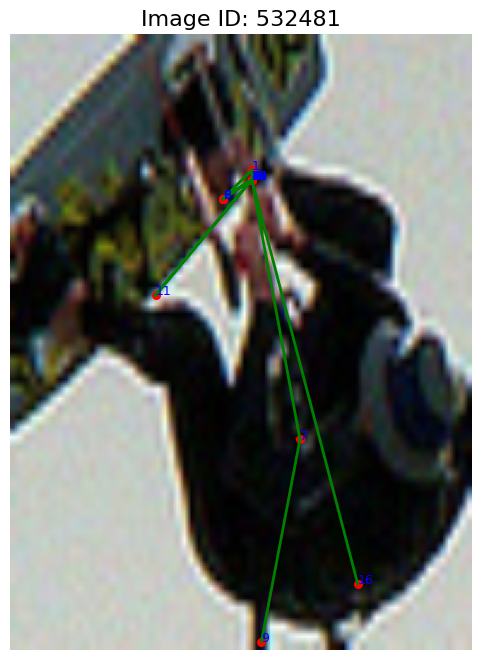

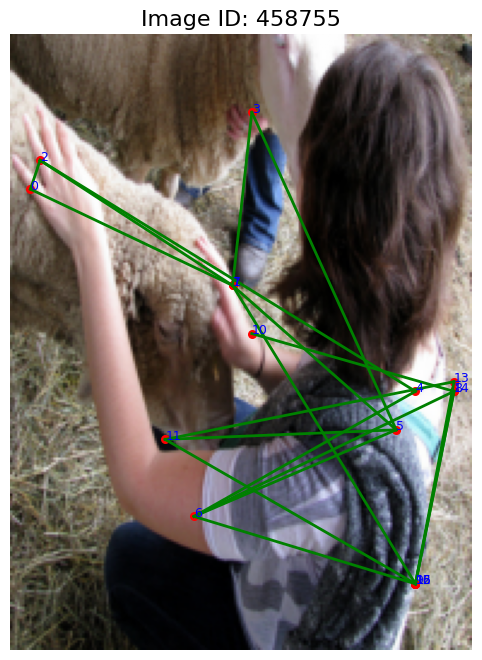

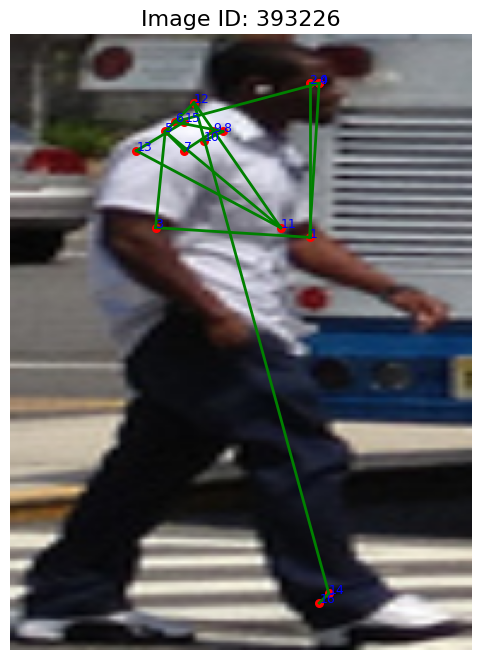

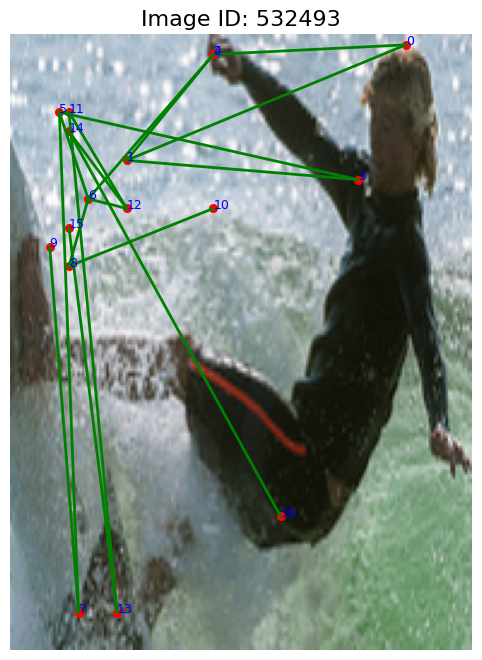

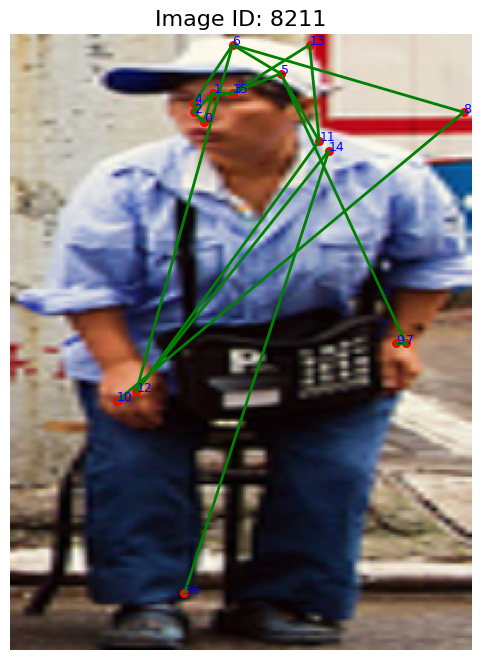

In [19]:
import matplotlib.pyplot as plt

def visualize_keypoints(image, keypoints, title="Predicted Keypoints", skeleton=None):
    """
    Visualize the image with annotated keypoints.
    
    Args:
        image (Tensor): Input image as a tensor (C, H, W).
        keypoints (ndarray): Predicted keypoints (NUM_KEYPOINTS, 3) with x, y, confidence.
        title (str): Title of the visualization.
        skeleton (list of tuple): Optional list of connections between keypoints (e.g., [(0, 1), (1, 2)]).
    """
    # Convert image tensor to numpy array for display
    image = image.permute(1, 2, 0).numpy()  # Convert to H x W x C
    image = (image - image.min()) / (image.max() - image.min())  # Normalize for display

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")

    # Plot the keypoints
    for i, (x, y, confidence) in enumerate(keypoints):
        if confidence > 0:  # Only plot visible keypoints
            plt.scatter(x, y, c="red", s=30, label=f"Keypoint {i}" if i == 0 else None)
            plt.text(x, y, f"{i}", fontsize=9, color="blue")

    # Plot skeleton if provided
    if skeleton:
        for connection in skeleton:
            p1, p2 = connection
            if keypoints[p1][2] > 0 and keypoints[p2][2] > 0:  # Only connect visible keypoints
                plt.plot(
                    [keypoints[p1][0], keypoints[p2][0]],
                    [keypoints[p1][1], keypoints[p2][1]],
                    "green",
                    linewidth=2,
                )

    plt.title(title, fontsize=16)
    plt.show()


# Example Skeleton for COCO Keypoints
COCO_SKELETON = [
    (15, 13), (13, 11), (16, 14), (14, 12), (11, 12),
    (5, 11), (6, 12), (5, 6), (5, 7), (6, 8),
    (7, 9), (8, 10), (1, 2), (0, 1), (0, 2),
    (1, 3), (2, 4), (3, 5), (4, 6)
]

# Example Usage with Test Dataset
for i in range(5):  # Visualize the first 5 examples
    img, _, _, meta = test_dataset[i]
    img = img.to(device)  # Move image to device

    with torch.no_grad():
        heatmaps = model(img.unsqueeze(0)).cpu().numpy()[0]  # Get predicted heatmaps for the single image

    # Extract predicted keypoints from heatmaps
    pred_keypoints = []
    for j in range(NUM_KEYPOINTS):
        heatmap = heatmaps[j]
        y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        confidence = float(np.max(heatmap))

        # Map x, y back to input image size
        pred_x = (x / OUTPUT_SIZE[1]) * INPUT_SIZE[0]
        pred_y = (y / OUTPUT_SIZE[0]) * INPUT_SIZE[1]
        pred_keypoints.append([pred_x, pred_y, confidence])
    
    pred_keypoints = np.array(pred_keypoints)

    # Visualize the image with keypoints
    visualize_keypoints(
        img.cpu(), 
        pred_keypoints, 
        title=f"Image ID: {meta['image_id']}", 
        skeleton=COCO_SKELETON
    )
